In [ ]:
storage_account_name = "yahoomusic"
storage_account_key = ""
container = "yahoomusic"



dbutils.fs.mount(
  source = f"wasbs://{container}@{storage_account_name}.blob.core.windows.net",
  mount_point = "/mnt/azureStorage",
  extra_configs = {f"fs.azure.account.key.{storage_account_name}.blob.core.windows.net": storage_account_key}
)

In [ ]:
dbutils.fs.mounts()

Out[10]: [MountInfo(mountPoint='/databricks-datasets', source='databricks-datasets', encryptionType=''),
 MountInfo(mountPoint='/mnt/azureStorage', source='wasbs://yahoomusic@yahoomusic.blob.core.windows.net', encryptionType=''),
 MountInfo(mountPoint='/databricks/mlflow-tracking', source='databricks/mlflow-tracking', encryptionType=''),
 MountInfo(mountPoint='/databricks-results', source='databricks-results', encryptionType=''),
 MountInfo(mountPoint='/databricks/mlflow-registry', source='databricks/mlflow-registry', encryptionType=''),
 MountInfo(mountPoint='/', source='DatabricksRoot', encryptionType='')]

In [ ]:
%fs ls "dbfs:/mnt/azureStorage"

path,name,size,modificationTime
dbfs:/mnt/azureStorage/genre-hierarchy.txt,genre-hierarchy.txt,4362,1682022374000
dbfs:/mnt/azureStorage/readme.txt,readme.txt,5684,1682022374000
dbfs:/mnt/azureStorage/song-attributes.txt,song-attributes.txt,2567765,1682022727000
dbfs:/mnt/azureStorage/test_0.txt,test_0.txt,29250779,1682022770000
dbfs:/mnt/azureStorage/train_0.txt,train_0.txt,1116948159,1682022996000


In [ ]:
ratings = spark.read \
  .option("delimiter", "\t") \
  .csv("/mnt/azureStorage/train_0.txt") \
  .toDF("userId", "songId", "rating")

ratings.show(5)

ratings = ratings.select(ratings.userId.cast("integer"), ratings.songId.cast("integer"), ratings.rating.cast("double"))

+------+------+------+
|userId|songId|rating|
+------+------+------+
|     0|   166|     5|
|     0|  2245|     4|
|     0|  3637|     4|
|     0|  5580|     4|
|     0|  5859|     4|
+------+------+------+
only showing top 5 rows



In [ ]:
song_attributes = spark.read \
  .option("delimiter", "\t") \
  .csv("/mnt/azureStorage/song-attributes.txt") \
  .toDF("songId", "albumId", "artistId", "genreId")
song_attributes = song_attributes.select(song_attributes.songId.cast("integer"), song_attributes.albumId.cast("integer"), song_attributes.artistId.cast("integer"), song_attributes.genreId.cast("integer"))

song_attributes.show(5)

+------+-------+--------+-------+
|songId|albumId|artistId|genreId|
+------+-------+--------+-------+
|     0|  12070|    8490|      0|
|     1|  19512|    7975|    134|
|     2|  18953|    3492|      0|
|     3|    695|    2653|      0|
|     4|    243|    2282|      0|
+------+-------+--------+-------+
only showing top 5 rows



In [ ]:
genre_hierarchy = spark.read \
  .option("delimiter", "\t") \
  .csv("/mnt/azureStorage/genre-hierarchy.txt") \
  .toDF("genreId", "parentGenreId", "level", "genreName")
genre_hierarchy = genre_hierarchy.select(genre_hierarchy.genreId.cast("integer"), genre_hierarchy.parentGenreId.cast("integer"), genre_hierarchy.level.cast("integer"), genre_hierarchy.genreName.cast("string"))
genre_hierarchy.show(5)


+-------+-------------+-----+----------------+
|genreId|parentGenreId|level|       genreName|
+-------+-------------+-----+----------------+
|      0|            0|    1|         Unknown|
|      1|            1|    1|Electronic/Dance|
|      2|            1|    2|         Ambient|
|      3|            2|    3|     Ambient Dub|
|      4|            2|    3|    Ambient Tech|
+-------+-------------+-----+----------------+
only showing top 5 rows



In [ ]:
ratings.count()

Out[2]: 76344627

In [ ]:
df = ratings.join(song_attributes, 'songId', 'left').join(genre_hierarchy, 'genreId', 'left')
df.show(5)

+-------+------+------+------+-------+--------+-------------+-----+---------+
|genreId|songId|userId|rating|albumId|artistId|parentGenreId|level|genreName|
+-------+------+------+------+-------+--------+-------------+-----+---------+
|      0|   166|     0|   5.0|   5303|    7231|            0|    1|  Unknown|
|      0|  2245|     0|   4.0|  14290|    3265|            0|    1|  Unknown|
|      0|  3637|     0|   4.0|  15761|     629|            0|    1|  Unknown|
|      0|  5580|     0|   4.0|   8324|    4761|            0|    1|  Unknown|
|      0|  5859|     0|   4.0|  19671|    4716|            0|    1|  Unknown|
+-------+------+------+------+-------+--------+-------------+-----+---------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col
df.filter(col('genreName') != 'Unknown').show(5)

+-------+------+------+------+-------+--------+-------------+-----+------------+
|genreId|songId|userId|rating|albumId|artistId|parentGenreId|level|   genreName|
+-------+------+------+------+-------+--------+-------------+-----+------------+
|    135| 17821|     0|     5|   8620|    2020|          134|    2|Classic Rock|
|    134| 60088|     0|     4|  15360|    3305|          134|    1|        Rock|
|    106|  1718|     1|     5|  11047|    2389|          106|    1|         Pop|
|     54|  2433|     1|     2|   7664|    7164|           54|    1|     Country|
|    106|  3436|     1|     5|   5748|    5417|          106|    1|         Pop|
+-------+------+------+------+-------+--------+-------------+-----+------------+
only showing top 5 rows



In [ ]:
# basic stats and sparsity
user_count = ratings.select("userId").distinct().count()
song_count = ratings.select("songId").distinct().count()
sparsity = 1 - (ratings.count() / (user_count * song_count))
print(f"The number of distinct users: {user_count}")
print(f"The number of distinct songs: {song_count}")
print(f"Sparsity of the data: {sparsity}")

The number of distinct users: 200000
The number of distinct songs: 136736
Sparsity of the data: 0.997208320157091


In [ ]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- songId: integer (nullable = true)
 |-- rating: double (nullable = true)



In [8]:
from pyspark.sql.functions import min, avg

In [9]:
# Min number of ratings for songs
ratings.groupBy("songId").count().select(min("count")).show()

+----------+
|min(count)|
+----------+
|        74|
+----------+



In [10]:
# Average number of ratings for songs
ratings.groupBy("songId").count().select(avg("count")).show()

+-----------------+
|       avg(count)|
+-----------------+
|558.3359685817926|
+-----------------+



In [55]:
# Min number of ratings for users
ratings.groupBy("userId").count().select(min("count")).show()

+----------+
|min(count)|
+----------+
|        20|
+----------+



In [56]:
# Avg number of ratings for users
ratings.groupBy("userId").count().select(avg("count")).show()

+----------+
|avg(count)|
+----------+
|381.723135|
+----------+



In [59]:
song_attributes.columns

['songId', 'albumId', 'artistId', 'genreId']

In [60]:
# Total number of distinct albums
song_attributes.select("albumId").distinct().count()

20543

In [61]:
# Total number of distinct artist
song_attributes.select("artistId").distinct().count()

9442

In [62]:
# Total number of distinct genres
song_attributes.select("genreId").distinct().count()

58

In [63]:
genre_hierarchy.columns

['genreId', 'parentGenreId', 'level', 'genreName']

In [64]:
# Total number of distinct parent genres
genre_hierarchy.select("parentGenreId").distinct().count()

37

## Feature Engineering

In [37]:
sample = ratings.sample(.005)

In [17]:
sample.count()

382032

In [22]:
sample.show(1)

+------+------+------+
|userId|songId|rating|
+------+------+------+
|     1| 42906|   5.0|
+------+------+------+
only showing top 1 row



In [23]:
song_attributes.show(1)

+------+-------+--------+-------+
|songId|albumId|artistId|genreId|
+------+-------+--------+-------+
|     0|  12070|    8490|      0|
+------+-------+--------+-------+
only showing top 1 row



In [24]:
genre_hierarchy.show(1)

+-------+-------------+-----+---------+
|genreId|parentGenreId|level|genreName|
+-------+-------------+-----+---------+
|      0|            0|    1|  Unknown|
+-------+-------------+-----+---------+
only showing top 1 row



In [38]:
sample_full = sample.join(song_attributes, on="songId", how="left")

In [39]:
sample_full.show(3)

+------+------+------+-------+--------+-------+
|songId|userId|rating|albumId|artistId|genreId|
+------+------+------+-------+--------+-------+
| 95852|     1|   2.0|  16864|    1974|      0|
|121520|     2|   2.0|    118|    5499|      0|
|  2033|     6|   5.0|   7575|    7548|      0|
+------+------+------+-------+--------+-------+
only showing top 3 rows



In [40]:
sample_full.printSchema()

root
 |-- songId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- albumId: integer (nullable = true)
 |-- artistId: integer (nullable = true)
 |-- genreId: integer (nullable = true)



In [ ]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.ml.recommendation import ALS

# One-hot encode genre
genreEncoder = OneHotEncoder(inputCols=["genreId"], outputCols=["genreVec"])
df = genreEncoder.fit(sample_full).transform(sample_full)

# Assemble features
featureCols = ["userId", "songId", "genreVec", "artistId"]
assembler = VectorAssembler(inputCols=featureCols, outputCol="features")
df = assembler.transform(df)

In [44]:

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA

assembler = VectorAssembler(inputCols=["artistId_embedding"], outputCol="artistId_features")
df = assembler.transform(df)

pca = PCA(k=10, inputCol="artistId_features", outputCol="artistId_embeddings")
model = pca.fit(df)
df = model.transform(df)


In [45]:
df.show()

+------+------+------+-------+--------+-------+-----------------+--------------------+
|songId|userId|rating|albumId|artistId|genreId|         genreVec|            features|
+------+------+------+-------+--------+-------+-----------------+--------------------+
| 95852|     1|   2.0|  16864|    1974|      0|  (215,[0],[1.0])|(218,[0,1,2,217],...|
|121520|     2|   2.0|    118|    5499|      0|  (215,[0],[1.0])|(218,[0,1,2,217],...|
|  2033|     6|   5.0|   7575|    7548|      0|  (215,[0],[1.0])|(218,[0,1,2,217],...|
| 32224|     6|   1.0|  17581|    2022|      0|  (215,[0],[1.0])|(218,[0,1,2,217],...|
| 36415|     6|   3.0|   1705|     481|      0|  (215,[0],[1.0])|(218,[0,1,2,217],...|
| 42011|     6|   5.0|   7169|    2105|      0|  (215,[0],[1.0])|(218,[0,1,2,217],...|
| 43799|     6|   4.0|  17179|    6011|      0|  (215,[0],[1.0])|(218,[0,1,2,217],...|
| 52022|     6|   5.0|    138|    2999|    106|(215,[106],[1.0])|(218,[0,1,108,217...|
| 53514|     6|   3.0|   7068|    5574|    

## Train the model on ALS

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
als = ALS(userCol="userId", itemCol="songId", ratingCol="rating", nonnegative=True, implicitPrefs=False)

In [ ]:
type(als)

Out[64]: pyspark.ml.recommendation.ALS

In [ ]:
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 50, 100]) \
    .addGrid(als.maxIter, [5, 50, 100]) \
    .addGrid(als.regParam, [.01, .05, .1]) \
    .build()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-3863082808769900> in <cell line: 1>()
      1 param_grid = ParamGridBuilder() \
----> 2     .addGrid(als.rank, [10, 50, 100]) \
      3     .addGrid(als.maxIter, [5, 50, 100]) \
      4     .addGrid(als.regParam, [.01, .05, .1]) \
      5     .build()

NameError: name 'als' is not defined

In [ ]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  27


In [ ]:
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)
print(cv)

CrossValidator_4f0d5522d025


In [ ]:
model = cv.fit(ratings)

In [ ]:
model.save('/cv27')

In [ ]:
best_model = model.bestModel
best_model.write().overwrite().save('/cv27_model')

In [ ]:
als = ALS(userCol="userId", itemCol="songId", ratingCol="rating", rank=50, maxIter=50, regParam=.05)

In [ ]:
model = als.fit(ratings)
model.write().overwrite().save('/model')

In [ ]:
from pyspark.ml.recommendation import ALSModel
model_loaded = ALSModel.load('/model')
model_loaded

Out[13]: ALSModel: uid=ALS_78be94afd140, rank=50

In [ ]:
"""
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 50, 100]) \
    .addGrid(als.maxIter, [5, 50, 100]) \
    .addGrid(als.regParam, [.01, .05, .1]) \
    .build()
"""

In [ ]:
import itertools
ranks = [10, 50, 100, 150]
maxIters = [5, 50, 100, 200]
regParams = [.01, .05, .1, .15]
param_grid = list(itertools.product(ranks, maxIters, regParams))
print(len(param_grid))

64


In [ ]:
(train, evaluation) = ratings.randomSplit([0.8, 0.2], seed=11)

In [ ]:
for idx, params in enumerate(param_grid[12:]):
    rank, maxIter, regParam = params
    
    als = ALS(userCol="userId", itemCol="songId", ratingCol="rating",
        rank=rank, maxIter=maxIter, regParam=regParam,
        nonnegative=True, implicitPrefs=False)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

    model = als.fit(train)
    predictions = model.transform(evaluation)
    rmse = evaluator.evaluate(predictions)
    model_str = f"rank{rank}_maxIter{maxIter}_regParam_{str(regParam)[2:]}"
    model.write().overwrite().save(f'/models/{model_str}')
    print(f"{idx+1}/64: {rank=}, {maxIter=}, {regParam=}, {rmse=}")

## Tuning Rank parameter

In [ ]:
# sample train datset
sample = ratings.sample(0.01)
test_sample, train_sample = sample.randomSplit([0.2, 0.8])
train_sample.count()

Out[6]: 609976

In [ ]:
ranks_50 = {}

In [ ]:

for rank in range(150,151):
    als = ALS(userCol="userId", itemCol="songId", ratingCol="rating",
        rank=rank, maxIter=50, regParam=0.05,
        nonnegative=True, implicitPrefs=False)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

    model = als.fit(train_sample)
    predictions = model.transform(test_sample)
    predictions = predictions.dropna(subset=['prediction'])
    rmse = evaluator.evaluate(predictions)

    ranks_50[rank] = rmse
    print(f"{rank=}, {rmse=}")

rank=150, rmse=1.7157478812876805


In [ ]:
ranks_50

Out[30]: {1: 1.5738254559812397,
 2: 1.7862062410533497,
 3: 1.830120381576723,
 4: 1.844480201435181,
 5: 1.8443998551133574,
 6: 1.833095297169888,
 7: 1.8215729324578764,
 8: 1.8095579813535516,
 9: 1.8021120902463084,
 10: 1.795516325522329,
 11: 1.7887097093359647,
 12: 1.7796768753020331,
 13: 1.7703265081119,
 14: 1.7692787523052425,
 15: 1.7651032653333134,
 16: 1.7571136542119237,
 17: 1.7580747610422685,
 18: 1.7528779162616985,
 19: 1.751732248092146,
 20: 1.7497395190308473,
 21: 1.7457419648124402,
 22: 1.744828993047792,
 23: 1.7448290657166032,
 24: 1.7406102807320454,
 25: 1.7406522465608711,
 26: 1.7398375882501547,
 27: 1.7397161243130663,
 28: 1.7375032653103177,
 29: 1.737227358697863,
 30: 1.7366466380797465,
 31: 1.7343397740655777,
 32: 1.733996196441696,
 33: 1.7354131267699846,
 34: 1.7325105979610314,
 35: 1.732347120130002,
 36: 1.730183685922928,
 37: 1.7308144172711677,
 38: 1.7293240014290532,
 39: 1.729731229439743,
 40: 1.7290512805903302,
 41: 1.7292155

In [ ]:
1.7157478812876805 / 1.795516325522329

Out[33]: 0.95557353441972

In [ ]:
1.0648437967725464 * 0.95557353441972

Out[34]: 1.0175365504868563

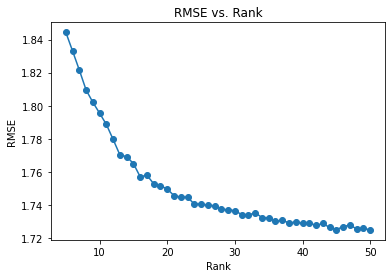

In [ ]:
import matplotlib.pyplot as plt

rks = list(ranks_50.keys())[4:]
rmse = list(ranks_50.values())[4:]

plt.scatter(rks, rmse)
plt.plot(rks, rmse)

plt.xlabel('Rank')
plt.ylabel('RMSE')
plt.title('RMSE vs. Rank')

plt.show()

## Final Model

In [ ]:
ranks = [10, 50, 100, 150]
maxIters = [5, 50, 100, 200]
regParams = [.01, .05, .1, .15]

In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
rank, maxIter, regParam = 50, 100, 0.05

als = ALS(userCol="userId", itemCol="songId", ratingCol="rating",
    rank=rank, maxIter=maxIter, regParam=regParam,
    nonnegative=True, implicitPrefs=False)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

model = als.fit(train)
predictions = model.transform(evaluation)
rmse = evaluator.evaluate(predictions)
model_str = f"rank{rank}_maxIter{maxIter}_regParam_{str(regParam)[2:]}"
model.write().overwrite().save(f'/models/{model_str}')
print(f"{rank=}, {maxIter=}, {regParam=}, {rmse=}")

## Test the Model

In [ ]:
test = spark.read \
  .option("delimiter", "\t") \
  .csv("/mnt/azureStorage/test_0.txt") \
  .toDF("userId", "songId", "rating")

test = test.select(test.userId.cast("integer"), test.songId.cast("integer"), test.rating.cast("double"))
test.show()


+------+------+------+
|userId|songId|rating|
+------+------+------+
|     0|  7171|   5.0|
|     0|  8637|   4.0|
|     0| 21966|   4.0|
|     0| 35821|   5.0|
|     0| 82446|   5.0|
|     0| 90409|   5.0|
|     0|107410|   5.0|
|     0|131919|   5.0|
|     0|132685|   3.0|
|     0|136507|   3.0|
|     1|  3342|   5.0|
|     1|  7522|   1.0|
|     1| 25363|   2.0|
|     1| 38997|   5.0|
|     1| 43685|   1.0|
|     1| 45488|   4.0|
|     1| 62770|   3.0|
|     1|109450|   3.0|
|     1|122506|   3.0|
|     1|130621|   5.0|
+------+------+------+
only showing top 20 rows



In [ ]:
test_user_count = test.select("userId").distinct().count()
test_song_count = test.select("songId").distinct().count()
print(f"The number of distinct users in test data: {test_user_count}")
print(f"The number of distinct songs in test data: {test_song_count}")

The number of distinct users in test data: 200000
The number of distinct songs in test data: 127771


In [ ]:
users_notin_test = ratings.select("userId").subtract(test.select("userId"))
users_notin_test.count()

Out[26]: 0

In [ ]:
print("  Rank:", model._java_obj.parent().getRank())
print("  MaxIter:", model._java_obj.parent().getMaxIter())
print("  RegParam:", model._java_obj.parent().getRegParam())

  Rank: 50
  MaxIter: 50
  RegParam: 0.05


In [ ]:
predictions = model_loaded.transform(test)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)

In [ ]:
rmse

Out[42]: 1.0631797330840782

In [ ]:
predictions.show()

+------+------+------+----------+
|userId|songId|rating|prediction|
+------+------+------+----------+
| 89516| 29453|   4.0|  2.276237|
|173093| 46483|   3.0|  3.675692|
|173092| 48530|   1.0| 1.7472686|
|117833| 53691|   1.0| 1.8457206|
|145463| 60455|   3.0| 1.4073292|
|     1|109450|   3.0| 4.0602856|
| 59938|112032|   2.0| 2.7825067|
|117832|135533|   4.0|  2.331811|
|     1|  7522|   1.0|  1.550169|
| 59939| 15491|   4.0| 3.5277753|
| 89516| 70091|   3.0| 1.6540598|
|117832| 83361|   4.0| 4.9126153|
|117833|101018|   4.0| 2.4562166|
| 59937| 39552|   2.0| 2.2335367|
|173092| 52627|   1.0| 1.4489079|
| 30359|117612|   4.0| 4.0956225|
| 30360|  6572|   5.0|  5.364228|
|173093| 90890|   3.0|  4.540982|
| 30359|127733|   5.0| 5.0687876|
|     0|  7171|   5.0|  4.135555|
+------+------+------+----------+
only showing top 20 rows



In [ ]:
predictions = predictions.join(song_attributes, 'songId', 'left')\
    .join(genre_hierarchy, 'genreId', 'left')

In [ ]:
from pyspark.sql.functions import col, avg, min, max, desc

In [ ]:
predictions.groupBy('userId').count().select(max('count')).show()

+----------+
|max(count)|
+----------+
|        10|
+----------+



In [ ]:
predictions.filter(col('userId') == 145206).orderBy(desc('prediction')).show()

+-------+------+------+------+----------+-------+--------+-------------+-----+---------+
|genreId|songId|userId|rating|prediction|albumId|artistId|parentGenreId|level|genreName|
+-------+------+------+------+----------+-------+--------+-------------+-----+---------+
|    114|121751|145206|   3.0| 5.2566304|  10316|    5227|          114|    1|      R&B|
|    114|127486|145206|   5.0|   5.05774|  10316|    5227|          114|    1|      R&B|
|      0| 12061|145206|   5.0| 4.9672146|  10905|    3220|            0|    1|  Unknown|
|      0|128821|145206|   5.0| 4.7035966|  10905|    3220|            0|    1|  Unknown|
|    114| 77413|145206|   5.0| 4.5306716|  10316|    5227|          114|    1|      R&B|
|    114| 30374|145206|   3.0| 4.5276423|  10316|    5227|          114|    1|      R&B|
|    114| 19815|145206|   5.0|  4.104283|  15731|    8034|          114|    1|      R&B|
|    114| 44714|145206|   5.0|  3.928204|  10316|    5227|          114|    1|      R&B|
|      0|115151|14520

In [ ]:
predictions.filter(col('prediction') < 0).count()

Out[32]: 1066

In [ ]:
predictions.filter(col('genreName') == 'Unknown').count()

Out[46]: 1749719

In [ ]:
# choosing userId who has less than 5 'Unknown' genreId
predictions.filter(col("genreName") != "Unknown") \
    .groupBy("userId") \
    .count() \
    .filter(col("count") > 5) \
    .select("userId") \
    .show()

+------+
|userId|
+------+
|124861|
|122992|
|145206|
|145030|
|141997|
|118144|
|123006|
|135314|
|144878|
|125428|
|122095|
|140345|
|120699|
|130006|
|136328|
|138923|
|118524|
|131445|
|120076|
|144197|
+------+
only showing top 20 rows



## Recommend

In [ ]:

from pyspark.sql.functions import col
from pyspark.sql.functions import isnan
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

def recommend_songs(model, user_song_matrix, user_id, num_recommendations):
    user_rated_songs = user_song_matrix.filter(col("userId") == user_id).select("songId")
    all_songs = user_song_matrix.select("songId").distinct()
    unrated_songs = all_songs.subtract(user_rated_songs)

    assembler = VectorAssembler(inputCols=["songId"], outputCol="features")
    unrated_songs = assembler.transform(unrated_songs)
    unrated_songs = unrated_songs.select("songId", "features")

    recommendations = model.transform(unrated_songs)
    recommendations = recommendations.orderBy("prediction", ascending=False).limit(num_recommendations)
    recommendations = recommendations.select("songId", "prediction")

    return recommendations

recommendations = recommend_songs(model, user_song_matrix, 123, 10)
recommendations.show()


## Plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import pyspark.sql.functions as F
rating_counts = ratings.groupBy("rating").count()
rame to a Pandas dataframe for easier plotting
rating_counts_pd = rating_counts.toPandas()

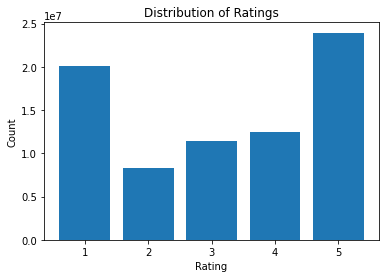

In [ ]:
plt.bar(rating_counts_pd['rating'], rating_counts_pd['count'], align='center'#, color='black'
)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.grid(False)

plt.show()

In [ ]:
from pyspark.sql.functions import avg, count

song_ratings = ratings.groupBy('songId')\
                .agg(avg('rating').alias('avg_rating'), 
                     count('rating').alias('num_ratings'))\
                .orderBy('num_ratings', ascending=False)


In [ ]:
song_ratings.show(2)

+------+------------------+-----------+
|songId|        avg_rating|num_ratings|
+------+------------------+-----------+
| 72309| 3.095482316013676|      35682|
|105433|3.4090239736113563|      33954|
+------+------------------+-----------+
only showing top 2 rows



In [ ]:
song_ratings = song_ratings.toPandas()

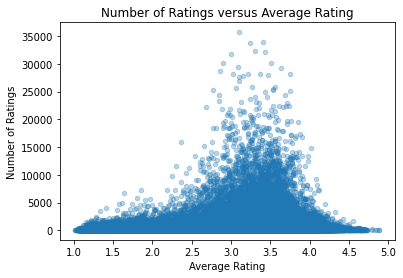

In [ ]:


plt.scatter(song_ratings['avg_rating'], song_ratings['num_ratings'], alpha=0.3, s=20)

plt.xlabel('Average Rating')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings versus Average Rating')

plt.show()


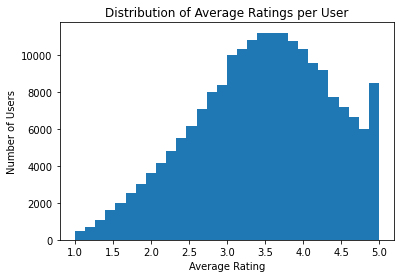

In [ ]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Assuming that the ratings dataframe is already defined

# Group the ratings by userId and calculate the average rating
avg_ratings_per_user = ratings.groupBy("userId").agg(F.mean("rating").alias("avg_rating"))

# Convert the PySpark dataframe to a Pandas dataframe
avg_ratings_per_user_pd = avg_ratings_per_user.toPandas()

# Plot a histogram of the average rating values
plt.hist(avg_ratings_per_user_pd["avg_rating"], bins=30)

# Add labels and a title to the plot
plt.xlabel("Average Rating")
plt.ylabel("Number of Users")
plt.title("Distribution of Average Ratings per User")
plt.show()


Out[62]: <AxesSubplot:xlabel='avg_rating', ylabel='Count'>

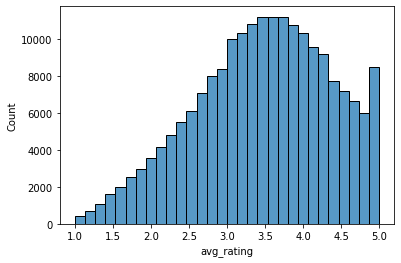

In [ ]:
sns.histplot(avg_ratings_per_user_pd["avg_rating"], bins=30)

In [ ]:
from time import sleep
sleep(3600)

In [ ]:
item_ratings = ratings.groupBy('songId').count().orderBy('count', ascending=False)

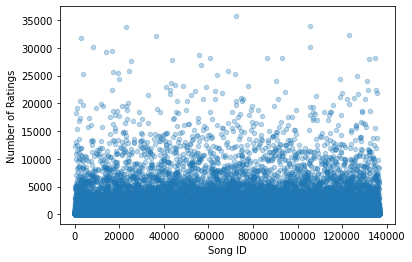

In [ ]:
plt.scatter(item_ratings.select('songId').rdd.map(lambda x: x[0]).collect(),
            item_ratings.select('count').rdd.map(lambda x: x[0]).collect(), alpha=0.3, s=20)
plt.xlabel('Song ID')
plt.ylabel('Number of Ratings')
plt.show()

In [ ]:
df.show(1)

+-------+------+------+------+-------+--------+-------------+-----+---------+
|genreId|songId|userId|rating|albumId|artistId|parentGenreId|level|genreName|
+-------+------+------+------+-------+--------+-------------+-----+---------+
|      0|   166|     0|   5.0|   5303|    7231|            0|    1|  Unknown|
+-------+------+------+------+-------+--------+-------------+-----+---------+
only showing top 1 row



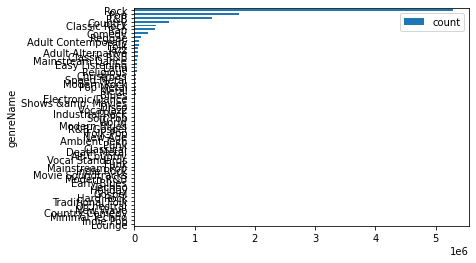

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import count, col

# Assuming your Spark dataframe is named "df" and the genre column is named "genre"
genre_counts = df.filter(df.genreName != "Unknown").groupBy('genreName').agg(count('*').alias('count'))
genre_counts_pd = genre_counts.toPandas()

# Plot horizontal bar chart
genre_counts_pd.sort_values(by='count').plot(kind='barh', x='genreName', y='count')

plt.show()


Out[63]: Text(0.5, 1.0, 'Number of rated genres (top 15)')

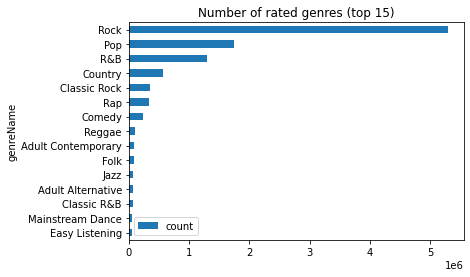

In [ ]:

df = genre_counts_pd.sort_values(by='count', ascending=False)[:15].sort_values(by='count')
df.plot(kind='barh', x='genreName', y='count')
plt.title("Number of rated genres (top 15)")